## Test Pyro4 Setup

In [1]:
import Pyro4
Pyro4.config.SERIALIZER = "pickle"
Pyro4.config.SERIALIZERS_ACCEPTED.add("pickle")
bot = Pyro4.Proxy("PYRONAME:remotelocobot@172.17.0.6")
bot.test_connection()

'Connected!'

In [2]:
from tokenize import String
import numpy as np
import os
import cv2
import json
from copy import deepcopy as copy
from IPython import embed
import sys
import time
import ray
from scipy.spatial.transform import Rotation
from pycocotools.coco import COCO
import glob
import argparse

def transform_pose(XYZ, current_pose):
    """
    Transforms the point cloud into geocentric frame to account for
    camera position
    Input:
        XYZ                     : ...x3
    current_pose            : camera position (x, y, theta (radians))
    Output:
        XYZ : ...x3
    """
    R = Rotation.from_euler("Z", current_pose[2]).as_matrix()
    XYZ = np.matmul(XYZ.reshape(-1, 3), R.T).reshape((-1, 3))
    XYZ[:, 0] = XYZ[:, 0] + current_pose[0]
    XYZ[:, 1] = XYZ[:, 1] + current_pose[1]
    return XYZ

def propogate_label(
    rgb_imgs: np.ndarray, 
    depth_imgs: np.ndarray, 
    label_maps: np.ndarray, 
    base_pose_data: np.ndarray,
    src_index: int, 
    propagation_step: int,

    # root_path: str,
    # src_img_indx: int,
    # src_label: np.ndarray,
    # propogation_step: int,
    # base_pose_data: np.ndarray,
    # out_dir: str,
):
    """Take the label for src_img_indx and propogate it to [src_img_indx - propogation_step, src_img_indx + propogation_step]
    Args:
        root_path (str): root path where images are stored
        src_img_indx (int): source image index
        src_label (np.ndarray): array with labeled images are stored (hwc format)
        propogation_step (int): number of steps to progate the label
        base_pose_data(np.ndarray): (x,y,theta)
        out_dir (str): path to store labeled propogation image
    """
    ### load the inputs ###
    # load img
    src_img = rgb_imgs[src_index]
    # load depth in mm
    src_depth = depth_imgs[src_index]
    # load robot pose for img index
    src_pose = base_pose_data[src_index]

    ### data needed to convert depth img to pointcloud ###
    # values extracted from pyrobot habitat agent
    intrinsic_mat = np.array([[256, 0, 256], [0, 256, 256], [0, 0, 1]])
    rot = np.array([[0.0, 0.0, 1.0], [-1.0, 0.0, 0.0], [0.0, -1.0, 0.0]])
    trans = np.array([0, 0, 0.6])
    # precompute some values necessary to depth to point cloud
    intrinsic_mat_inv = np.linalg.inv(intrinsic_mat)
    height, width, channels = src_img.shape
    img_resolution = (height, width)
    img_pixs = np.mgrid[0 : img_resolution[0] : 1, 0 : img_resolution[1] : 1]
    img_pixs = img_pixs.reshape(2, -1)
    img_pixs[[0, 1], :] = img_pixs[[1, 0], :]
    uv_one = np.concatenate((img_pixs, np.ones((1, img_pixs.shape[1]))))
    uv_one_in_cam = np.dot(intrinsic_mat_inv, uv_one)

    ### calculate point cloud in different frmaes ###
    # point cloud in camera frmae
    depth = (src_depth.astype(np.float32) / 1000.0).reshape(-1)
    pts_in_cam = np.multiply(uv_one_in_cam, depth)
    pts_in_cam = np.concatenate((pts_in_cam, np.ones((1, pts_in_cam.shape[1]))), axis=0)
    # point cloud in robot base frame
    pts_in_base = pts_in_cam[:3, :].T
    pts_in_base = np.dot(pts_in_base, rot.T)
    pts_in_base = pts_in_base + trans.reshape(-1)
    # point cloud in world frame (pyrobot)
    pts_in_world = transform_pose(pts_in_base, src_pose)

    ### figure out unique label values in provided gt label which is greater than 0 ###
    unique_pix_value = np.unique(label_maps.reshape(-1), axis=0)
    unique_pix_value = [i for i in unique_pix_value if np.linalg.norm(i) > 0]

    ### for each unique label, figure out points in wolrd frmae ###
    # first figure out pixel index
    indx = [zip(*np.where(label_maps == i)) for i in unique_pix_value]
    # convert pix index to index in point cloud
    # refer this https://www.codepile.net/pile/bZqJbyNz
    indx = [[i[0] * width + i[1] for i in j] for j in indx]
    # take out points in world space correspoinding to each unique label
    req_pts_in_world_list = [pts_in_world[indx[i]] for i in range(len(indx))]

    # images in which in which we want to label propagation based on the provided gt seg label
    image_range = [max(src_index - propagation_step, 0), src_index + propagation_step]
    # param usful to search nearest point cloud in a region
    kernal_size = 3

    annot_imgs = {}
    for img_indx in range(image_range[0], image_range[1]):
        print("img_index = {}".format(img_indx))

        ### create point cloud in wolrd frame for img_indx ###
        # get the robot pose value
        base_pose = base_pose_data[img_indx]
        # get the depth
        try:
            cur_depth = depth_imgs[img_indx]
        except:
            return
        # convert depth to point cloud in camera frmae
        cur_depth = (cur_depth.astype(np.float32) / 1000.0).reshape(-1)
        cur_pts_in_cam = np.multiply(uv_one_in_cam, cur_depth)
        cur_pts_in_cam = np.concatenate(
            (cur_pts_in_cam, np.ones((1, cur_pts_in_cam.shape[1]))), axis=0
        )
        # convert point cloud in camera fromae to base frame
        cur_pts_in_base = cur_pts_in_cam[:3, :].T
        cur_pts_in_base = np.dot(cur_pts_in_base, rot.T)
        cur_pts_in_base = cur_pts_in_base + trans.reshape(-1)
        # convert point cloud from base frame to world frmae
        cur_pts_in_world = transform_pose(cur_pts_in_base, base_pose)

        ### generate label for new img indx ###
        # crete annotation files with all zeros
        annot_img = np.zeros((height, width))
        # do label prpogation for each unique label in provided gt seg label
        for i, (req_pts_in_world, pix_color) in enumerate(
            zip(req_pts_in_world_list, unique_pix_value)
        ):
            # convert point cloud for label from world pose to current (img_indx) base pose
            pts_in_cur_base = copy(req_pts_in_world)
            pts_in_cur_base = transform_pose(pts_in_cur_base, (-base_pose[0], -base_pose[1], 0))
            pts_in_cur_base = transform_pose(pts_in_cur_base, (0.0, 0.0, -base_pose[2]))

            # conver point from current base to current camera frame
            pts_in_cur_cam = pts_in_cur_base - trans.reshape(-1)
            pts_in_cur_cam = np.dot(pts_in_cur_cam, rot)

            # conver pts in current camera frame into 2D pix values
            pts_in_cur_img = np.matmul(intrinsic_mat, pts_in_cur_cam.T).T
            pts_in_cur_img /= pts_in_cur_img[:, 2].reshape([-1, 1])

            # filter out index which fall beyond the shape of img size
            filtered_img_indx = np.logical_and(
                np.logical_and(0 <= pts_in_cur_img[:, 0], pts_in_cur_img[:, 0] < height),
                np.logical_and(0 <= pts_in_cur_img[:, 1], pts_in_cur_img[:, 1] < width),
            )

            # only consider depth matching for these points
            # filter out point based on projected depth value wold frmae, this helps us get rid of pixels for which view to the object is blocked by any other object, as in that was projected 3D point in wolrd frmae for the current pix wont match with 3D point in the gt provide label
            dist_thr = 5e-2  # this is in meter
            for pixel_index in range(len(filtered_img_indx)):
                if filtered_img_indx[pixel_index]:
                    # search in the region
                    gt_pix_depth_in_world = req_pts_in_world[pixel_index]
                    p, q = np.meshgrid(
                        range(
                            int(pts_in_cur_img[pixel_index][1] - kernal_size),
                            int(pts_in_cur_img[pixel_index][1] + kernal_size),
                        ),
                        range(
                            int(pts_in_cur_img[pixel_index][0] - kernal_size),
                            int(pts_in_cur_img[pixel_index][0] + kernal_size),
                        ),
                    )
                    loc = p * width + q
                    loc = loc.reshape(-1).astype(np.int)
                    loc = np.clip(loc, 0, width * height - 1).astype(np.int)

                    if (
                        min(np.linalg.norm(cur_pts_in_world[loc] - gt_pix_depth_in_world, axis=1))
                        > dist_thr
                    ):
                        filtered_img_indx[pixel_index] = False

            # take out filtered pix values
            pts_in_cur_img = pts_in_cur_img[filtered_img_indx]

            # step to take care of quantization erros
            pts_in_cur_img = np.concatenate(
                (
                    np.concatenate(
                        (
                            np.ceil(pts_in_cur_img[:, 0]).reshape(-1, 1),
                            np.ceil(pts_in_cur_img[:, 1]).reshape(-1, 1),
                        ),
                        axis=1,
                    ),
                    np.concatenate(
                        (
                            np.floor(pts_in_cur_img[:, 0]).reshape(-1, 1),
                            np.floor(pts_in_cur_img[:, 1]).reshape(-1, 1),
                        ),
                        axis=1,
                    ),
                    np.concatenate(
                        (
                            np.ceil(pts_in_cur_img[:, 0]).reshape(-1, 1),
                            np.floor(pts_in_cur_img[:, 1]).reshape(-1, 1),
                        ),
                        axis=1,
                    ),
                    np.concatenate(
                        (
                            np.floor(pts_in_cur_img[:, 0]).reshape(-1, 1),
                            np.ceil(pts_in_cur_img[:, 1]).reshape(-1, 1),
                        ),
                        axis=1,
                    ),
                )
            )
            pts_in_cur_img = pts_in_cur_img[:, :2].astype(int)

            # filter out index which fall beyonf the shape of img size, had to perform this step again to take care if any out of the image size point is introduced by the above quantization step
            pts_in_cur_img = pts_in_cur_img[
                np.logical_and(
                    np.logical_and(0 <= pts_in_cur_img[:, 0], pts_in_cur_img[:, 0] < height),
                    np.logical_and(0 <= pts_in_cur_img[:, 1], pts_in_cur_img[:, 1] < width),
                )
            ]

            # number of pointf for the label found in cur img
            print("pts in cam = {}".format(len(pts_in_cur_cam)))

            # assign label to correspoinding pix values
            annot_img[pts_in_cur_img[:, 1], pts_in_cur_img[:, 0]] = pix_color

        # store the annotation file
        annot_imgs[img_indx] = annot_img.astype(np.uint32)
    return annot_imgs

/private/home/hollisma/.conda/envs/droidlet_env/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
  "update your install command.", FutureWarning)


In [3]:
from PIL import Image
%matplotlib inline
import matplotlib.pyplot as plt

def display_sample(rgb_obs, semantic_obs, depth_obs):
    rgb_img = Image.fromarray(rgb_obs)

    semantic_img = Image.new("P", (semantic_obs.shape[1], semantic_obs.shape[0]))
    semantic_img.putpalette(d3_40_colors_rgb.flatten())
    semantic_img.putdata((semantic_obs.flatten() % 40).astype(np.uint8))
    semantic_img = semantic_img.convert("RGBA")

    depth_img = Image.fromarray((depth_obs / 10 * 255).astype(np.uint8), mode="L")

    arr = [rgb_img, semantic_img, depth_img]
    titles = ['rgb', 'semantic', 'depth']
    plt.figure(figsize=(12 ,8))
    for i, data in enumerate(arr):
        ax = plt.subplot(1, 3, i+1)
        ax.axis('off')
        ax.set_title(titles[i])
        plt.imshow(data)
    plt.show()

In [4]:
import numpy as np
d3_40_colors_rgb: np.ndarray = np.array(
    [
        [31, 119, 180],
        [174, 199, 232],
        [255, 127, 14],
        [255, 187, 120],
        [44, 160, 44],
        [152, 223, 138],
        [214, 39, 40],
        [255, 152, 150],
        [148, 103, 189],
        [197, 176, 213],
        [140, 86, 75],
        [196, 156, 148],
        [227, 119, 194],
        [247, 182, 210],
        [127, 127, 127],
        [199, 199, 199],
        [188, 189, 34],
        [219, 219, 141],
        [23, 190, 207],
        [158, 218, 229],
        [57, 59, 121],
        [82, 84, 163],
        [107, 110, 207],
        [156, 158, 222],
        [99, 121, 57],
        [140, 162, 82],
        [181, 207, 107],
        [206, 219, 156],
        [140, 109, 49],
        [189, 158, 57],
        [231, 186, 82],
        [231, 203, 148],
        [132, 60, 57],
        [173, 73, 74],
        [214, 97, 107],
        [231, 150, 156],
        [123, 65, 115],
        [165, 81, 148],
        [206, 109, 189],
        [222, 158, 214],
    ],
    dtype=np.uint8,
)

In [5]:
rgb, d, segm = bot.get_rgbd_segm()

In [6]:
# segm = np.load('hi.npy', allow_pickle=True)

# These are the inputs from the dashboard that are to be used in the label prop script
rgb0 = np.load("rgb0.npy", allow_pickle=True)
rgb1 = np.load("rgb1.npy", allow_pickle=True)
depth0 = np.load("depth0.npy", allow_pickle=True)
depth1 = np.load("depth1.npy", allow_pickle=True)
labels = np.load("label_maps.npy", allow_pickle=True)
pose = np.load("base_pose.npy", allow_pickle=True)

rgb_imgs = np.array([rgb0, rgb1])
depth_imgs = np.array([depth0, depth0])

segm = propogate_label(rgb_imgs, depth_imgs, labels, pose, 1, 1)

# print(segm)
print(np.unique(segm[0], return_counts=True))
print(np.unique(labels[0], return_counts=True))


img_index = 0


/private/home/hollisma/.conda/envs/droidlet_env/lib/python3.7/site-packages/ipykernel_launcher.py:178: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/private/home/hollisma/.conda/envs/droidlet_env/lib/python3.7/site-packages/ipykernel_launcher.py:179: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your c

pts in cam = 5260
img_index = 1
pts in cam = 5260
(array([0, 1], dtype=uint32), array([262020,    124]))
(array([0, 1]), array([259514,   2630]))


In [7]:
print(segm[0].shape)
print(labels.shape)
print(depth0.shape)

(512, 512)
(2, 512, 512)
(512, 512)


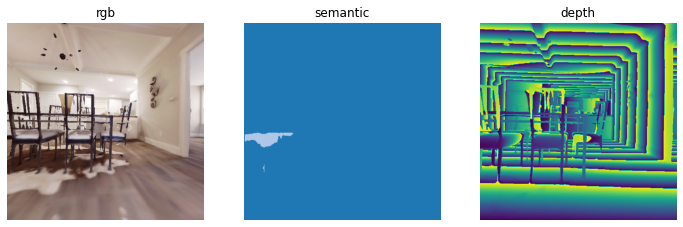

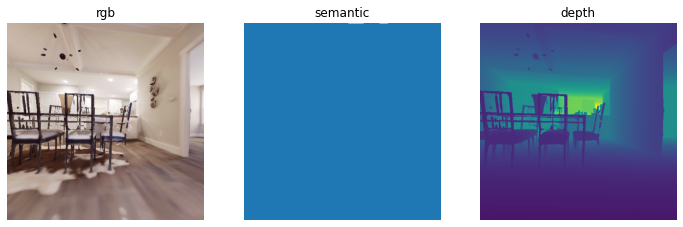

In [8]:
depth_img = cv2.normalize(depth0, None, 0, 255, cv2.NORM_MINMAX)
display_sample(rgb, labels[0], depth_img) # showing input labels and depth
display_sample(rgb, segm[0], d)

In [9]:
# 1) save dashboard inputs to disk
# 2) define label prop function
# 3) load inputs from disk and call label prop
# 4) visualize output with display_sample